In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass, asdict
import csv
import json
from dataclasses import dataclass, asdict
from pathlib import Path
from typing import Optional
from datetime import datetime
from main import sample_episode
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

In [2]:
# from scipy.special import theta
import numpy as np

# --- Jacobi theta3 helper: theta(3, z, q) ---
try:
    # If your SciPy has it, this will work in your environment
    from scipy.special import theta as _theta

    def theta3(z, q):
        # SciPy version: vectorized
        return _theta(3, z, q)

except Exception:
    # Fallback: mpmath (scalar; we convert to float)
    import mpmath as mp

    def theta3(z, q):
        return float(mp.jtheta(3, z, q))


def heat_kernel_S1(t, x, y, wrap=True):
    """
    Heat kernel on S^1 using theta3.
    x,y are angles in radians (typically in [0, 2π)).
    wrap=True wraps differences into (-π, π] for numerical stability.
    """
    d = x - y
    if wrap:
        d = (d + np.pi) % (2 * np.pi) - np.pi  # wrap to (-π, π]
    q = np.exp(-t)
    return (1 / (2 * np.pi)) * theta3(d / 2, q)


def heat_kernel_torus_2d(t, x_vec, y_vec, wrap=True):
    """
    Product kernel on S^1 x S^1 (2D torus).
    x_vec, y_vec are length-2 arrays: [angle1, angle2].
    """
    return heat_kernel_S1(t, x_vec[0], y_vec[0], wrap=wrap) * \
           heat_kernel_S1(t, x_vec[1], y_vec[1], wrap=wrap)

In [3]:
def gram_matrix_heat_torus_2d(X, t, wrap=True):
    """
    Build Gram matrix K where K[i,j] = heat_kernel_torus_2d(t, X[i], X[j]).
    X: shape (n, 2)
    """
    X = np.asarray(X, dtype=float)
    if X.ndim != 2 or X.shape[1] != 2:
        raise ValueError("X must have shape (n, 2) for 2D inputs.")

    n = X.shape[0]
    K = np.empty((n, n), dtype=float)

    # Fill symmetrically
    for i in range(n):
        for j in range(i, n):
            v = heat_kernel_torus_2d(t, X[i], X[j], wrap=wrap)
            K[i, j] = v
            K[j, i] = v
    return K


def solve_alphas(K, y, lam):
    """
    Solve (K + lam I) alpha = y without forming an explicit inverse.
    """
    K = np.asarray(K, dtype=float)
    y = np.asarray(y, dtype=float).reshape(-1)
    n = K.shape[0]
    if K.shape != (n, n):
        raise ValueError("K must be square.")
    if y.shape[0] != n:
        raise ValueError("y must have length n.")
    if lam <= 0:
        raise ValueError("lam should be > 0 for stable regularization.")

    # A = K + lam * np.eye(n)
    alpha = np.linalg.solve(K @ K + lam * K, K @ y)

    # # Cholesky is best when A is SPD (lam>0 typically ensures this)
    # try:
    #     L = np.linalg.cholesky(A)
    #     alpha = np.linalg.solve(L.T, np.linalg.solve(L, y))
    # except np.linalg.LinAlgError:
    #     # Fallback if numerical issues arise
    #     alpha = np.linalg.solve(A, y)

    return alpha


def fit_kernel_machine_heat_torus(X, y, t, lam, wrap=True):
    """
    Convenience: compute Gram matrix + alpha.
    """
    K = gram_matrix_heat_torus_2d(X, t=t, wrap=wrap)
    alpha = solve_alphas(K, y, lam=lam)
    return K, alpha


def predict_heat_torus(X_train, alpha, X_test, t, wrap=True):
    """
    f(x) = sum_i alpha_i k(x, x_i)
    """
    X_train = np.asarray(X_train, dtype=float)
    X_test  = np.asarray(X_test, dtype=float)
    alpha   = np.asarray(alpha, dtype=float).reshape(-1)

    n = X_train.shape[0]
    if alpha.shape[0] != n:
        raise ValueError("alpha length must match number of training points.")

    yhat = np.empty(X_test.shape[0], dtype=float)
    for m, x in enumerate(X_test):
        s = 0.0
        for i in range(n):
            s += alpha[i] * heat_kernel_torus_2d(t, x, X_train[i], wrap=wrap)
        yhat[m] = s
    return yhat

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

p = torch.tensor([np.pi, np.pi], device=device)

In [5]:
def periodic_func(x,p):
    return np.cos(x[..., 0]) *(np.sin(x[..., 1])**2)

K_context:2   Mean error over 30 episodes: 2.304725959233936 ± 1.063102509460396
K_context:4   Mean error over 30 episodes: 1.3364279440401567 ± 0.9947835591494586
K_context:6   Mean error over 30 episodes: 0.7951066041875736 ± 0.751570556124531
K_context:8   Mean error over 30 episodes: 0.8258660130877812 ± 0.7684977799430041
K_context:10   Mean error over 30 episodes: 0.4160524884457697 ± 0.48711903634354875
K_context:12   Mean error over 30 episodes: 0.4999862646312556 ± 0.503569993766623
K_context:14   Mean error over 30 episodes: 0.4146447264385421 ± 0.4718023892587864
K_context:16   Mean error over 30 episodes: 0.31258710826714825 ± 0.3438786762716093
K_context:30   Mean error over 30 episodes: 0.1990181370800059 ± 0.332687801912976
K_context:50   Mean error over 30 episodes: 0.1689643468146743 ± 0.21184710092294337
K_context:100   Mean error over 30 episodes: 0.11003202698358348 ± 0.14087221718395315


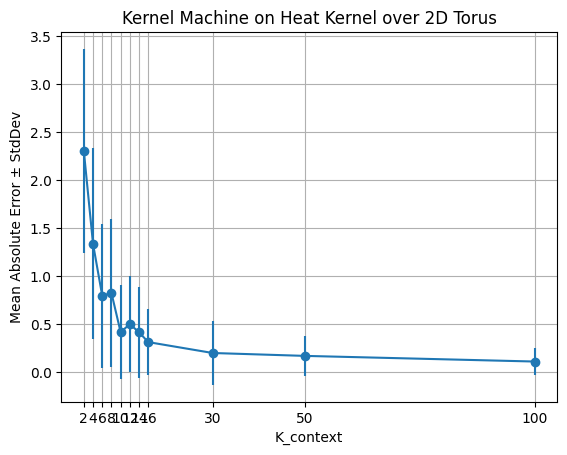

In [16]:
batch_size = 1
num_episodes = 30
means = np.array([])
stds = np.array([])
context_lengths = [2,4,6,8,10,12,14,16,30,50, 100]
for K_context in context_lengths:    
    this_vals = np.zeros(num_episodes)
    for rep in range(num_episodes):  # multiple samples to average over
        min = 100

        tokens, y_q = sample_episode(batch_size, K_context, p, device)
        # Test various (t_tilde, lam_tilde) combinations
        for t_tilde in [0.5]:
            for lam_tilde in [1e-8]:

                X = tokens.cpu().numpy()[0,0:K_context,0:2]  # (K,2)
                y = tokens.cpu().numpy()[0,0:K_context,2]  # (K,2)

                X_test = tokens.cpu().numpy()[0,-1:,0:2]
                # X_test = tokens.cpu().numpy()[0,0:1,0:2]
                try :
                    K, alpha = fit_kernel_machine_heat_torus(X, y, t=t_tilde, lam=lam_tilde)
                    y_pred = predict_heat_torus(X, alpha, X_test, t=t_tilde)
                    if np.abs(y_pred - y_q.cpu().numpy()) < min:
                        min = np.abs(y_pred - y_q.cpu().numpy())
                        min_t = t_tilde
                    # print(f"y_pred:{y_pred.item()}, y:{y_q.cpu().numpy()}, t_tilde:{t_tilde}, lam_tilde:{lam_tilde}   error {np.abs(y_pred - y_q.cpu().numpy())}")

                except np.linalg.LinAlgError:
                    pass
                    # print(f"LinAlgError for t_tilde:{t_tilde}, lam_tilde:{lam_tilde}")   
        # Keep track of minimum error across hyperparameters  
        # print(f"Minimum error achieved: {min}")
        this_vals[rep] = min[0]
    mean_error = np.mean(this_vals)
    std_error = np.std(this_vals)
    means = np.append(means, mean_error)
    stds = np.append(stds, std_error)
    print(f"K_context:{K_context}   Mean error over {num_episodes} episodes: {mean_error} ± {std_error}")
    
plt.errorbar(context_lengths, means, yerr=stds, fmt='-o')
plt.xlabel('K_context')
plt.ylabel('Mean Absolute Error ± StdDev')
plt.title('Kernel Machine on Heat Kernel over 2D Torus')
plt.xticks(context_lengths)
plt.grid(True)
plt.show()  

In [50]:
from scipy.spatial.distance import cdist
def SoftMaxKernel(X, t=1/2):
    real_X = np.column_stack([np.cos(X[...,0]), np.sin(X[...,0]), np.cos(X[...,1]), np.sin(X[...,1])])
    dist_mat =  cdist(real_X,real_X)**2
    exp_x = np.exp(-dist_mat/(4*t))
    return exp_x/np.sum(exp_x, axis=1)[:, np.newaxis]

def fit_kernel_machine_softmax(X, y, t, lam, wrap=True):
    """
    Convenience: compute Gram matrix + alpha.
    """
    K = SoftMaxKernel(X, t=t)
    alpha = solve_alphas(K, y, lam=lam)
    return K, alpha

In [51]:
def exp_dist_kernel(X, t=1/2):
    real_X = np.column_stack([np.cos(X[...,0]), np.sin(X[...,0]), np.cos(X[...,1]), np.sin(X[...,1])])
    dist_mat =  cdist(real_X,real_X)**2
    exp_x = np.exp(-dist_mat/(4*t))
    return exp_x

def fit_kernel_machine_exp(X, y, t, lam, wrap=True):
    """
    Convenience: compute Gram matrix + alpha.
    """
    K = exp_dist_kernel(X, t=t)
    alpha = solve_alphas(K, y, lam=lam)
    return K, alpha

In [47]:
print(tokens.shape)

torch.Size([1, 3, 4])


In [58]:
batch_size = 1
num_episodes = 30
context_lengths = [2,4,6,8,10,12,14,16,30, 50, 100]
ts = [0.0001]
lams = [1e-8, 0.1]

models = {'softmax': fit_kernel_machine_softmax, 'heat': fit_kernel_machine_heat_torus, 'exp': fit_kernel_machine_exp}
min_for_model = {model: 0 for model in models.keys()}
means_for_models = {model: np.array([]) for model in models.keys()}
stds_for_models = {model: np.array([]) for model in models.keys()}
for K_context in context_lengths:    
    this_vals_for_model ={model: np.zeros(num_episodes) for model in models.keys()}
    for rep in range(num_episodes):  # multiple samples to average over
        min_for_model = {model: 100 for model in models.keys()}

        tokens, y_q = sample_episode(batch_size, K_context, p, device)
        # Test various (t_tilde, lam_tilde) combinations
        for t_tilde in ts:
            for lam_tilde in lams:
                for model in models.keys():
                    func = models[model]
                    min = min_for_model[model]
                    X = tokens.cpu().numpy()[0,0:K_context,0:2]  # (K,2)
                    y = tokens.cpu().numpy()[0,0:K_context,2]  # (K,2)

                    X_test = tokens.cpu().numpy()[0,-1:,0:2]
                
                    try :
                        K, alpha = func(X, y, t=t_tilde, lam=lam_tilde)
                        y_pred = predict_heat_torus(X, alpha, X_test, t=t_tilde)
                        if np.abs(y_pred - y_q.cpu().numpy()) < min:
                            min_for_model[model] = np.abs(y_pred - y_q.cpu().numpy())[0]

                        
                        # print(f"y_pred:{y_pred.item()}, y:{y_q.cpu().numpy()}, t_tilde:{t_tilde}, lam_tilde:{lam_tilde}   error {np.abs(y_pred - y_q.cpu().numpy())}")

                    except np.linalg.LinAlgError:
                        pass
                        # print(f"y_pred:{y_pred.item()}, y:{y_q.cpu().numpy()}, t_tilde:{t_tilde}, lam_tilde:{lam_tilde}   error {np.abs(y_pred - y_q.cpu().numpy())}")
        for model in models.keys():
            this_vals_for_model[model][rep] = min_for_model[model]
    for model in models.keys():
        mean_error = np.mean(this_vals_for_model[model])
        std_error = np.std(this_vals_for_model[model])
        means_for_models[model] = np.append(means_for_models[model], mean_error)
        stds_for_models[model] = np.append(stds_for_models[model], std_error)
        print(f"{model=} K_context:{K_context}   Mean error over {num_episodes} episodes: {mean_error} ± {std_error}")


model='softmax' K_context:2   Mean error over 30 episodes: 2.5138307750225066 ± 0.8335500601835916
model='heat' K_context:2   Mean error over 30 episodes: 2.5138307750225066 ± 0.8335500601835916
model='exp' K_context:2   Mean error over 30 episodes: 2.5138307750225066 ± 0.8335500601835916
model='softmax' K_context:4   Mean error over 30 episodes: 2.2151828984419506 ± 0.6981463623844008
model='heat' K_context:4   Mean error over 30 episodes: 2.2151828984419506 ± 0.6981463623844008
model='exp' K_context:4   Mean error over 30 episodes: 2.2151828984419506 ± 0.6981463623844008
model='softmax' K_context:6   Mean error over 30 episodes: 2.1427258491516112 ± 1.0758715712874318
model='heat' K_context:6   Mean error over 30 episodes: 2.1427258491516112 ± 1.0758715712874318
model='exp' K_context:6   Mean error over 30 episodes: 2.1427258491516112 ± 1.0758715712874318
model='softmax' K_context:8   Mean error over 30 episodes: 2.356036138534546 ± 0.9085042982588077
model='heat' K_context:8   Mean 

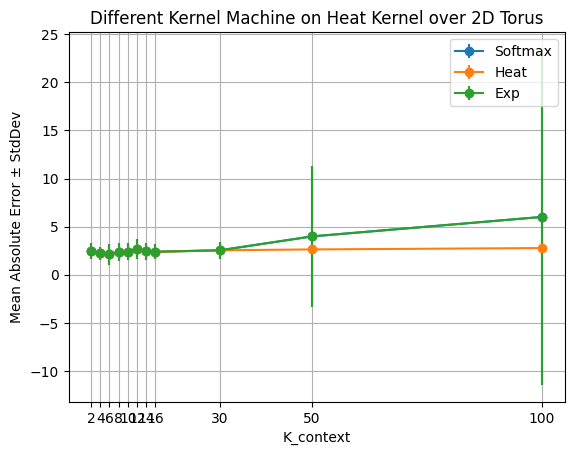

In [59]:
for model in models.keys():
    means = means_for_models[model]

    stds = stds_for_models[model]
    plt.errorbar(context_lengths, means, yerr=stds, fmt='-o', label=model.capitalize())
plt.xlabel('K_context')
plt.ylabel('Mean Absolute Error ± StdDev')
plt.title('Different Kernel Machine on Heat Kernel over 2D Torus')
plt.xticks(context_lengths)
plt.grid(True)
plt.legend()
plt.show()  

In [ ]:
batch_size = 1
num_episodes = 30
means = np.array([])
stds = np.array([])
context_lengths = [2,4,6,8,10,12,14,16,32, 64, 128, 200, 300]
ts = [0.01, 0.05, 0.1, 0.5, 1, 2, 3, 4,  5, 10, 20, 50, 100, 200]
lams = [1e-8, 1e-7, 1e-6, 1e5, 1e-4, 1e-3, 1e-2, 0.1]
for K_context in context_lengths:    
    this_vals = np.zeros(num_episodes)
    for rep in range(num_episodes):  # multiple samples to average over
        min = 100

        tokens, y_q = sample_episode(batch_size, K_context, p, device, func=periodic_func)
        # Test various (t_tilde, lam_tilde) combinations
        for t_tilde in ts:
            for lam_tilde in lams:

                X = tokens.cpu().numpy()[0,0:K_context,0:2]  # (K,2)
                y = tokens.cpu().numpy()[0,0:K_context,2]  # (K,2)

                X_test = tokens.cpu().numpy()[0,-1:,0:2]
                # X_test = tokens.cpu().numpy()[0,0:1,0:2]
                try :
                    K, alpha = fit_kernel_machine_exp(X, y, t=t_tilde, lam=lam_tilde)
                    y_pred = predict_heat_torus(X, alpha, X_test, t=t_tilde)
                    if np.abs(y_pred - y_q.cpu().numpy()) < min:
                        min = np.abs(y_pred - y_q.cpu().numpy())
                        min_t = t_tilde
                    # print(f"y_pred:{y_pred.item()}, y:{y_q.cpu().numpy()}, t_tilde:{t_tilde}, lam_tilde:{lam_tilde}   error {np.abs(y_pred - y_q.cpu().numpy())}")

                except np.linalg.LinAlgError:
                    pass
                    # print(f"LinAlgError for t_tilde:{t_tilde}, lam_tilde:{lam_tilde}")  
        print(min_t)    
        # Keep track of minimum error across hyperparameters  
        # print(f"Minimum error achieved: {min}")
        this_vals[rep] = min[0]
    mean_error = np.mean(this_vals)
    std_error = np.std(this_vals)
    means = np.append(means, mean_error)
    stds = np.append(stds, std_error)
    print(f"K_context:{K_context}   Mean error over {num_episodes} episodes: {mean_error} ± {std_error}")
    
plt.errorbar(context_lengths, means, yerr=stds, fmt='-o')
plt.xlabel('K_context')
plt.ylabel('Mean Absolute Error ± StdDev')
plt.title('Exp Kernel Machine on Heat Kernel over 2D Torus')
plt.xticks(context_lengths)
plt.grid(True)
plt.show()  